In [95]:
import cvxpy as cp
import numpy as np
from tqdm import tqdm

In [96]:
def solve_graphical_lasso(S, gamma):
    """
    Solve the graphical LASSO problem using CVXPY.
    
    Parameters:
    - S (np.ndarray): Positive definite covariance matrix (n x n)
    - gamma (float): Regularization parameter (gamma > 0)
    
    Returns:
    - X_opt (np.ndarray): Optimal precision matrix (n x n)
    """
    n = S.shape[0]
    X = cp.Variable((n, n), symmetric=True)
    
    # Enforce positive definiteness
    constraints = [X >> 0]
    
    # Objective function
    obj = cp.trace(S @ X) - cp.log_det(X) + gamma * cp.norm1(cp.vec(X - cp.diag(cp.diag(X))))
    
    problem = cp.Problem(cp.Minimize(obj), constraints)
    problem.solve()

    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("Solver did not converge!")

    return X.value

Gamma: 0.01, g(X): 4.0006, h(X): 0.0210
Gamma: 0.02, g(X): 4.0016, h(X): 0.0338
Gamma: 0.03, g(X): 4.0044, h(X): 0.0528
Gamma: 0.05, g(X): 4.0121, h(X): 0.0786
Gamma: 0.08, g(X): 4.0325, h(X): 0.1054
Gamma: 0.13, g(X): 4.0620, h(X): 0.1358
Gamma: 0.22, g(X): 4.0968, h(X): 0.1828
Gamma: 0.36, g(X): 4.1821, h(X): 0.1977
Gamma: 0.60, g(X): 4.3122, h(X): 0.1572
Gamma: 1.00, g(X): 4.5031, h(X): 0.0155


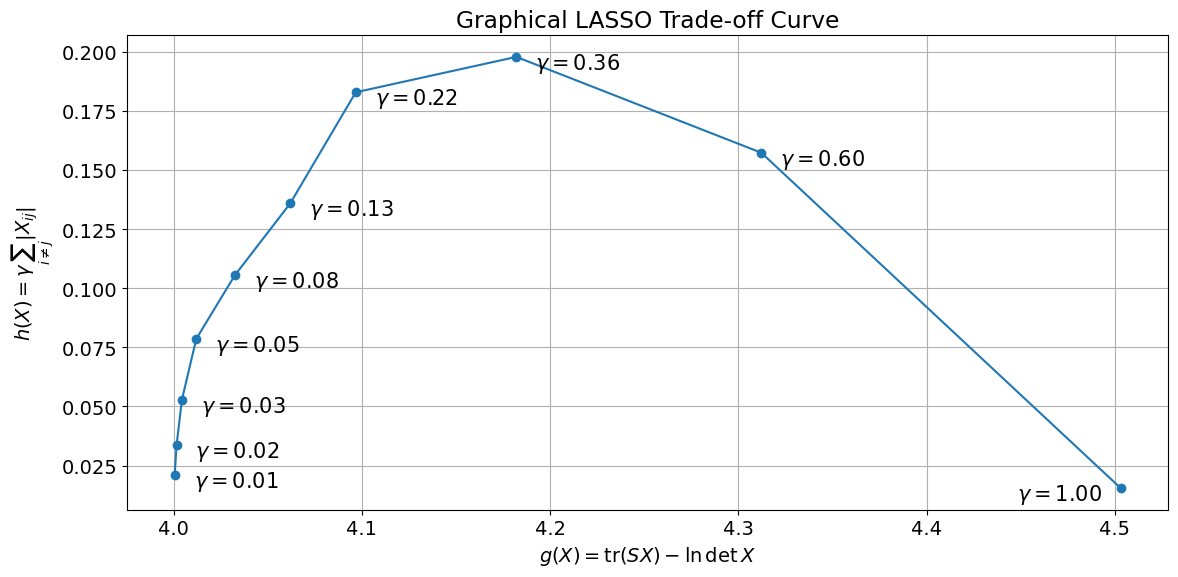

In [97]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt



def compute_g_cvx(S,X):
    return cp.trace(S @ X) - cp.log_det(X)
def compute_h_cvx(X,gamma):
    return gamma * cp.norm1(cp.vec(X - cp.diag(cp.diag(X))))

def compute_objective(S,X,gamma):
    return compute_g_cvx(S,X) + compute_h_cvx(X,gamma)

def solve_graphical_lasso(S, gamma):
    n = S.shape[0]
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0]
    obj = compute_objective(S, X, gamma)
    problem = cp.Problem(cp.Minimize(obj), constraints)
    problem.solve()
    if problem.status not in ["optimal", "optimal_inaccurate"]:
        raise ValueError("Solver failed")
    return X.value

# Covariance matrix from the image
S = np.array([
    [ 1.00, -0.50,  0.10, -0.90],
    [-0.50,  1.25, -0.05,  1.05],
    [ 0.10, -0.05,  0.26, -0.09],
    [-0.90,  1.05, -0.09,  5.17]
])

# Generate gamma values logarithmically spaced
gamma_vals = np.logspace(-2, 0, 10)
gs = []
hs = []

for gamma in gamma_vals:
    X_star = solve_graphical_lasso(S, gamma)
    g = compute_g_cvx(S, X_star).value
    h = compute_h_cvx(X_star, gamma).value
    gs.append(g)
    hs.append(h)
    print(f"Gamma: {gamma:.2f}, g(X): {g:.4f}, h(X): {h:.4f}")

# Plotting the trade-off curve with updated labels
plt.figure(figsize=(12, 6))
plt.plot(gs, hs, marker='o')
plt.xlabel(r'$g(X)=\operatorname{tr}(S X)-\ln \operatorname{det} X$')
plt.ylabel(r'$h(X)=\gamma \sum_{i \neq j}\left|X_{i j}\right|$')
plt.title('Graphical LASSO Trade-off Curve')
plt.grid(True)
plt.tight_layout()
for i, gamma in enumerate(gamma_vals[:-1]):
    plt.text(gs[i]+0.01, hs[i]-0.005, rf'$\gamma=${gamma:.2f}', fontsize=15, ha='left')
plt.text(gs[-1]-0.01, hs[-1]-0.005, rf'$\gamma=${gamma_vals[-1]:.2f}', fontsize=15, ha='right')
plt.savefig('graphical_lasso_tradeoff.pdf', dpi=300)
plt.show()

# Proximal Method

In [98]:
from numpy.linalg import eigvals
from scipy.linalg import inv
from numpy.linalg import slogdet

# Check if X_k is positive definite
def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False
    

def compute_g(S, X):
    sign, logdet = slogdet(X)
    if sign <= 0:
        return np.inf
    return np.trace(S @ X) - logdet

def compute_h(X, gamma):
    return gamma * np.sum(np.abs(X - np.diag(np.diag(X))))

def prox(X,t,gamma):
    """
    Proximal operator for the graphical LASSO problem.
    
    Parameters:
    - X (np.ndarray): Input matrix
    - t (float): Step size
    - gamma (float): Regularization parameter
    
    Returns:
    - np.ndarray: Output matrix after applying the proximal operator
    """
    n = X.shape[0]
    diag_X = np.diag(np.diag(X))
    off_diag_X = X - diag_X
    
    # Soft-thresholding for off-diagonal elements
    prox_off_diag = np.sign(off_diag_X) * np.maximum(0,np.abs(off_diag_X) - t * gamma)
    
    # Combine diagonal and off-diagonal parts
    return diag_X + prox_off_diag


def backtrack_line_search(X_k,prox, g,g_grad_X_k,gamma,t_init=1.5, beta=0.85):
    t = t_init
    X_kp1 = prox(X_k-t*g_grad_X_k,t,gamma) 
    while True:
        if is_positive_definite(X_kp1): #np.all(eigvals(X_kp1) > 0):
            if g(X_kp1) <= g(X_k)  +  np.vdot(g_grad_X_k,X_kp1-X_k)   + 1/(2*t) * np.linalg.norm(X_kp1 - X_k, ord='fro')**2:    
                break 
        t *= beta
        X_kp1 = prox(X_k-t*g_grad_X_k,t,gamma)

    return X_kp1,t

def g_grad(S,X):
    return S-inv(X)


def duality_gap(S, X, gamma):
    try:
        X_inv = inv(X)
    except np.linalg.LinAlgError:
        return 89999999#np.inf

    U = X_inv - S
    U = np.where(np.eye(U.shape[0]), 0, np.clip(U, -gamma, gamma))

    S_plus_U = S + U
    if True: #is_positive_definite(S_plus_U):   # np.all(eigvals(S_plus_U) > 0):
        sign, logdet = slogdet(S_plus_U)
        if sign <= 0:
            return np.inf
        return compute_g(S, X) + compute_h(X, gamma) - logdet - X.shape[0]
    else:
        return 988888888#np.inf

def proximal_method(S,prox, g,g_grad, h, gamma, eps=1e-2, X_init=None,max_iter=1000,beta=0.85):
    """
    Proximal gradient descent method.
    
    Parameters:
    - prox (function): Proximal operator function
    - g (function): Objective function
    - g_grad (function): Gradient of the objective function
    
    Returns:
    - np.ndarray: Optimal solution
    """
    n = S.shape[0]
    if X_init is None:
        X_k = np.eye(n)  # Initial guess
    else:
        X_k = X_init
    t = 1.0  # Initial step size

    gap = 0
    for i in (pbar:=tqdm(range(max_iter), desc=f"Iterations ∆={gap:.2f}")):

        g_grad_x_k = g_grad(X_k)
        X_k, _ = backtrack_line_search(X_k, prox, g, g_grad_x_k, gamma,t_init=t,beta=beta)
        gap = duality_gap(S, X_k, gamma)
 
        pbar.set_description(f"Iterations ∆={gap:.2f}")
        if gap <= eps:
            break
        
        
    return X_k

gamma =0.1
X_k = proximal_method(S, prox, lambda X: compute_g(S,X), lambda X: g_grad(S,X), lambda X: compute_h(X,gamma), gamma=gamma)
print(X_k)
print(prox(X_k,1,gamma))

# Check if X_k is positive definite
def is_positive_definite(matrix):
    try:
        np.linalg.cholesky(matrix)
        return True
    except np.linalg.LinAlgError:
        return False

print("Is X_k positive definite?", is_positive_definite(X_k))


Iterations ∆=0.01:   9%|▊         | 87/1000 [00:00<00:01, 554.48it/s]

[[ 1.22454092  0.28790459  0.          0.13597576]
 [ 0.28790459  0.9977746   0.         -0.13805824]
 [ 0.          0.          3.33420534  0.        ]
 [ 0.13597576 -0.13805824  0.          0.2429097 ]]
[[ 1.22454092  0.18790459  0.          0.03597576]
 [ 0.18790459  0.9977746   0.         -0.03805824]
 [ 0.          0.          3.33420534  0.        ]
 [ 0.03597576 -0.03805824  0.          0.2429097 ]]
Is X_k positive definite? True


Gamma: 0.01, g(X): 4.0006, h(X): 0.0210
Gamma: 0.02, g(X): 4.0016, h(X): 0.0338
Gamma: 0.03, g(X): 4.0044, h(X): 0.0528
Gamma: 0.05, g(X): 4.0121, h(X): 0.0786
Gamma: 0.08, g(X): 4.0325, h(X): 0.1054
Gamma: 0.13, g(X): 4.0620, h(X): 0.1358
Gamma: 0.22, g(X): 4.0968, h(X): 0.1828
Gamma: 0.36, g(X): 4.1821, h(X): 0.1977
Gamma: 0.60, g(X): 4.3122, h(X): 0.1572
Gamma: 1.00, g(X): 4.5031, h(X): 0.0155


Iterations ∆=0.01:   9%|▉         | 90/1000 [00:00<00:02, 382.84it/s]


Gamma: 0.01, g(X): 4.0108, h(X): 0.0198


Iterations ∆=0.01:  11%|█▏        | 114/1000 [00:00<00:00, 908.45it/s]


Gamma: 0.02, g(X): 4.0136, h(X): 0.0317


Iterations ∆=0.01:  12%|█▏        | 124/1000 [00:00<00:01, 592.88it/s]


Gamma: 0.03, g(X): 4.0171, h(X): 0.0499


Iterations ∆=0.01:   6%|▋         | 65/1000 [00:00<00:01, 858.31it/s]


Gamma: 0.05, g(X): 4.0245, h(X): 0.0751


Iterations ∆=0.01:   7%|▋         | 70/1000 [00:00<00:01, 609.58it/s]


Gamma: 0.08, g(X): 4.0450, h(X): 0.1027


Iterations ∆=0.01:   8%|▊         | 79/1000 [00:00<00:01, 539.20it/s]


Gamma: 0.13, g(X): 4.0714, h(X): 0.1358


Iterations ∆=0.01:   8%|▊         | 76/1000 [00:00<00:01, 666.98it/s]


Gamma: 0.22, g(X): 4.1064, h(X): 0.1828


Iterations ∆=0.01:  10%|▉         | 95/1000 [00:00<00:01, 717.59it/s]


Gamma: 0.36, g(X): 4.1915, h(X): 0.1978


Iterations ∆=0.01:   7%|▋         | 70/1000 [00:00<00:00, 994.77it/s]


Gamma: 0.60, g(X): 4.3222, h(X): 0.1561


Iterations ∆=0.01:   7%|▋         | 73/1000 [00:00<00:02, 457.60it/s]


Gamma: 1.00, g(X): 4.5129, h(X): 0.0156


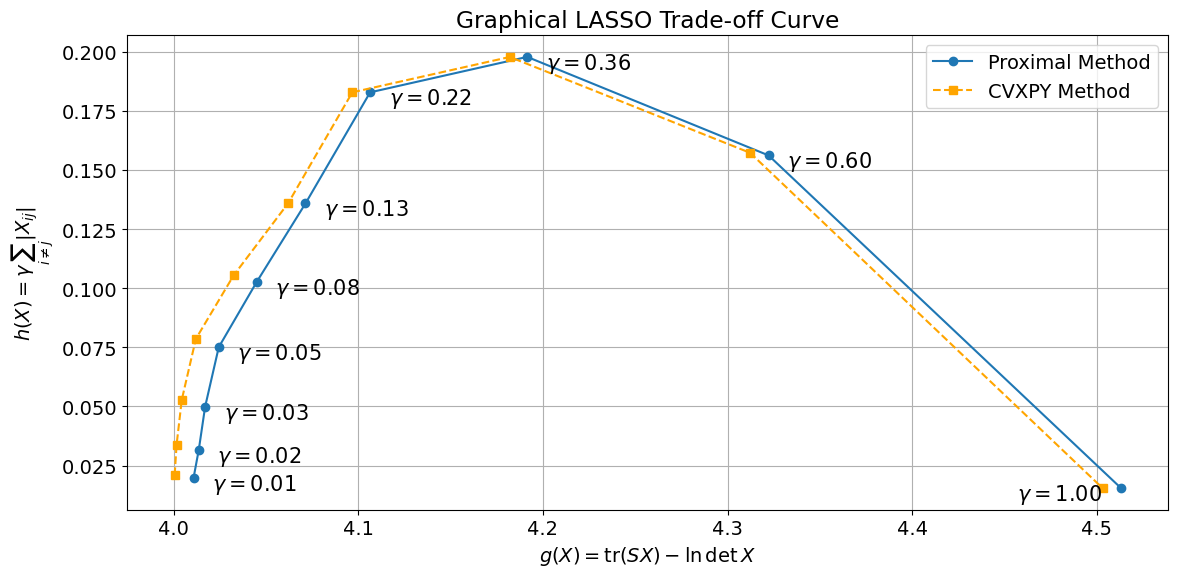

In [99]:
# Plotting the trade-off curves for both methods
plt.figure(figsize=(12, 6))


# Generate gamma values logarithmically spaced
gamma_vals = np.logspace(-2, 0, 10)
gs_cvx = []
hs_cvx = []

for gamma in gamma_vals:
    X_star = solve_graphical_lasso(S, gamma)
    g = compute_g_cvx(S, X_star).value
    h = compute_h_cvx(X_star, gamma).value
    gs_cvx.append(g)
    hs_cvx.append(h)
    print(f"Gamma: {gamma:.2f}, g(X): {g:.4f}, h(X): {h:.4f}")


gs_prox = []
hs_prox = []


for gamma in gamma_vals:
    X_star = proximal_method(S, prox, lambda X: compute_g(S,X), lambda X: g_grad(S,X), lambda X: compute_h(X,gamma), gamma=gamma)
    g_val = compute_g(S, X_star)
    h_val = compute_h(X_star, gamma)
    gs_prox.append(g_val)
    hs_prox.append(h_val)
    print(f"Gamma: {gamma:.2f}, g(X): {g_val:.4f}, h(X): {h_val:.4f}")


# Proximal method
plt.plot(gs_prox, hs_prox, marker='o', label='Proximal Method')

# CVXPY method
plt.plot(gs_cvx, hs_cvx, marker='s', linestyle='--', color='orange', label='CVXPY Method')

# Labels and title
plt.xlabel(r'$g(X)=\operatorname{tr}(S X)-\ln \operatorname{det} X$')
plt.ylabel(r'$h(X)=\gamma \sum_{i \neq j}\left|X_{i j}\right|$')
plt.title('Graphical LASSO Trade-off Curve')
plt.grid(True)
plt.tight_layout()

# Annotate gamma values for Proximal Method
for i, gamma in enumerate(gamma_vals[:-1]):
    plt.text(gs_prox[i]+0.01, hs_prox[i]-0.005, rf'$\gamma=${gamma:.2f}', fontsize=15, ha='left')
plt.text(gs_prox[-1]-0.01, hs_prox[-1]-0.005, rf'$\gamma=${gamma_vals[-1]:.2f}', fontsize=15, ha='right')

# Legend
plt.legend()

# Save and show the plot
plt.savefig('graphical_lasso_tradeoff_combined.pdf', dpi=300)
plt.show()

# S&P 500

In [100]:
# Read the covariance matrix from the file
sp500_cov = np.loadtxt('sp500.txt')

# Define gamma values logarithmically spaced between 10^-2 and 10^-1
gamma_vals_sp500 = np.logspace(-2, -1, 10)[::-1]

# Initialize lists to store results
gs_sp500 = []
hs_sp500 = []
nonzeros_sp500 = []

# Use the proximal gradient method to solve the graphical LASSO problem
X_init = sp500_cov#np.eye(sp500_cov.shape[0])  # Initial guess for X

for gamma in gamma_vals_sp500:
    print(f"Gamma: {gamma:.2f}")
    # Solve the problem using the previous solution as the initial guess
    X_star_sp500 = proximal_method(sp500_cov, prox, lambda X: compute_g(sp500_cov, X), 
                                   lambda X: g_grad(sp500_cov, X), lambda X: compute_h(X, gamma), gamma=gamma, X_init=X_init, max_iter=2750, eps=1e-2,beta=0.5)
    g_val_sp500 = compute_g(sp500_cov, X_star_sp500)
    h_val_sp500 = compute_h(X_star_sp500, gamma)
    gs_sp500.append(g_val_sp500)
    hs_sp500.append(h_val_sp500)
    
    # Count the number of off-diagonal nonzeros in X_star_sp500
    nonzeros = np.sum(np.abs(X_star_sp500 - np.diag(np.diag(X_star_sp500))) > 1e-6)
    nonzeros_sp500.append(nonzeros)
    
    # Update the initial guess for the next iteration
    X_init = X_star_sp500


Gamma: 0.10


Iterations ∆=0.01:  94%|█████████▍| 2594/2750 [02:38<00:09, 16.40it/s]


Gamma: 0.08


Iterations ∆=0.01:  15%|█▌        | 423/2750 [00:27<02:32, 15.26it/s]


Gamma: 0.06


Iterations ∆=0.01:  29%|██▉       | 808/2750 [01:01<02:26, 13.24it/s]


Gamma: 0.05


Iterations ∆=0.01:  53%|█████▎    | 1467/2750 [02:04<01:49, 11.74it/s]


Gamma: 0.04


Iterations ∆=0.05: 100%|██████████| 2750/2750 [05:16<00:00,  8.68it/s]


Gamma: 0.03


Iterations ∆=0.26: 100%|██████████| 2750/2750 [04:49<00:00,  9.52it/s]


Gamma: 0.02


Iterations ∆=0.85: 100%|██████████| 2750/2750 [06:18<00:00,  7.27it/s] 


Gamma: 0.02


Iterations ∆=1.74: 100%|██████████| 2750/2750 [05:51<00:00,  7.83it/s] 


Gamma: 0.01


Iterations ∆=2.43: 100%|██████████| 2750/2750 [06:02<00:00,  7.59it/s] 


Gamma: 0.01


Iterations ∆=3.13: 100%|██████████| 2750/2750 [05:56<00:00,  7.70it/s] 


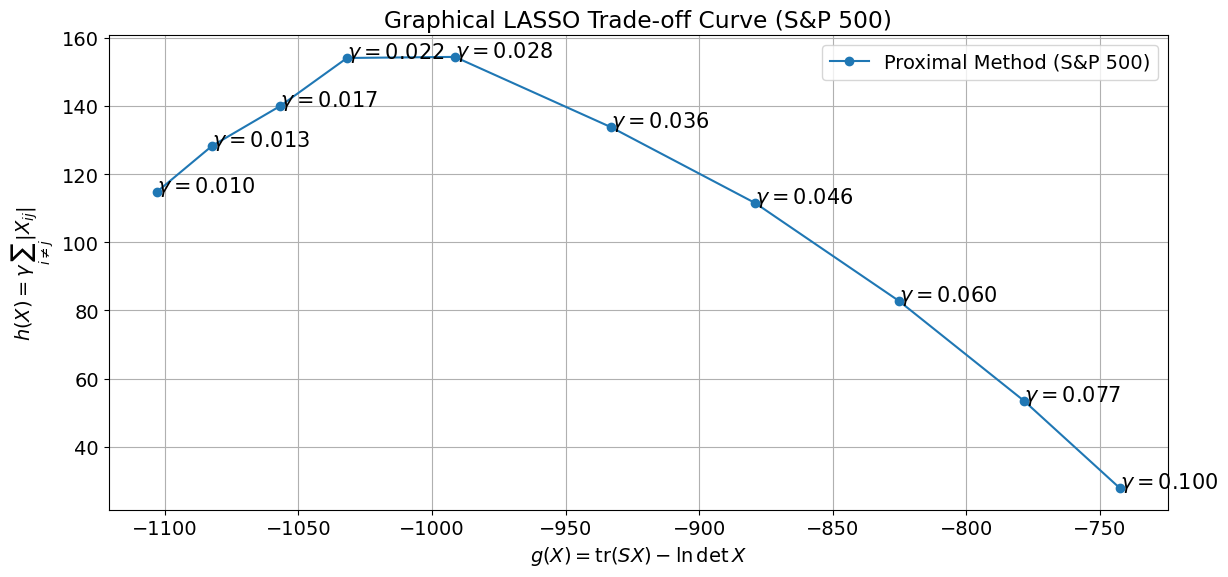

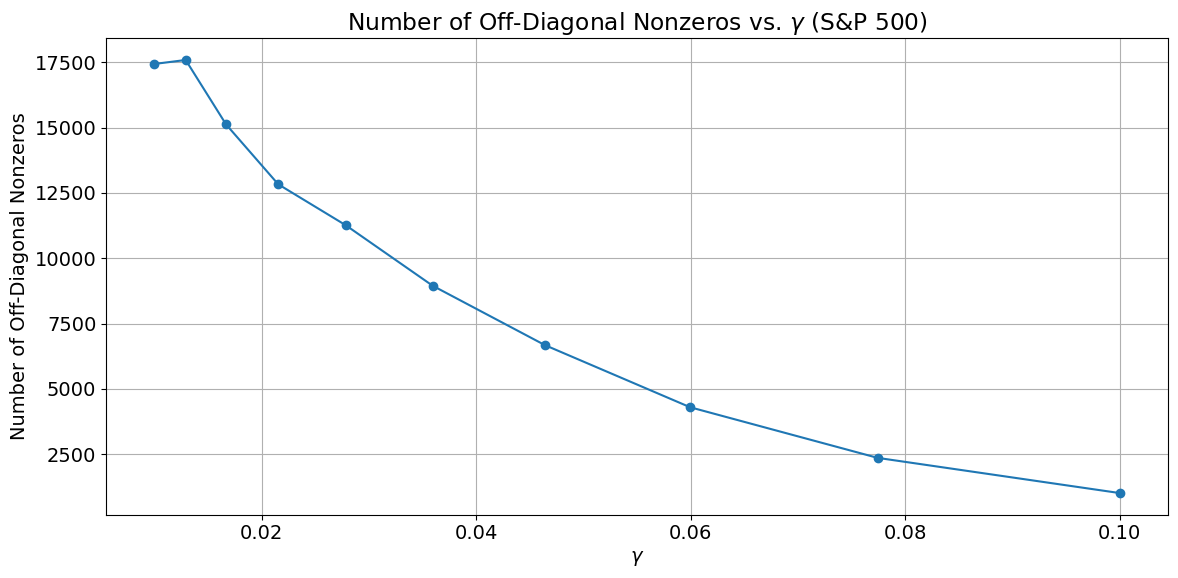

In [106]:
# Increase font size
plt.rcParams.update({'font.size': 14})

# Plot the trade-off curve
plt.figure(figsize=(12, 6))
plt.plot(gs_sp500, hs_sp500, marker='o', label='Proximal Method (S&P 500)')
plt.xlabel(r'$g(X)=\operatorname{tr}(S X)-\ln \operatorname{det} X$')
plt.ylabel(r'$h(X)=\gamma \sum_{i \neq j}\left|X_{i j}\right|$')
plt.title('Graphical LASSO Trade-off Curve (S&P 500)')
plt.grid(True)
plt.tight_layout()
plt.legend()
for i, gamma in enumerate(gamma_vals_sp500):
    plt.text(gs_sp500[i], hs_sp500[i]-0.005, rf'$\gamma=${gamma:.3f}', fontsize=15, ha='left')

#for i, gamma in enumerate(gamma_vals_sp500[3:6]):
    #plt.text(gs_sp500[3+i], hs_sp500[3+i]-0.005, rf'$\gamma=${gamma:.3f}', fontsize=15, ha='right')

#for i, gamma in enumerate(gamma_vals_sp500[6:9]):
    #plt.text(gs_sp500[6+i], hs_sp500[6+i]-0.005, rf'$\gamma=${gamma:.3f}', fontsize=15, ha='left')

#plt.text(gs_sp500[-1]-0.01, hs_sp500[-1]-0.005, rf'$\gamma=${gamma_vals_sp500[-1]:.3f}', fontsize=15, ha='right')

plt.savefig('sp500_tradeoff_curve.pdf', dpi=300)
plt.show()




# Plot the number of off-diagonal nonzeros as a function of gamma
plt.figure(figsize=(12, 6))
plt.plot(gamma_vals_sp500, nonzeros_sp500, marker='o')
#plt.xscale('log')
plt.xlabel(r'$\gamma$')
plt.ylabel('Number of Off-Diagonal Nonzeros')
plt.title('Number of Off-Diagonal Nonzeros vs. $\gamma$ (S&P 500)')
plt.grid(True)
plt.tight_layout()
plt.savefig('sp500_nonzeros_vs_gamma.pdf', dpi=300)
plt.show()

# Check with scipy implementaion

Gamma: 0.01, g(X): 4.0082, h(X): 0.0203
Gamma: 0.02, g(X): 4.0097, h(X): 0.0325
Gamma: 0.03, g(X): 4.0133, h(X): 0.0504
Gamma: 0.05, g(X): 4.0220, h(X): 0.0749
Gamma: 0.08, g(X): 4.0437, h(X): 0.1003
Gamma: 0.13, g(X): 4.0683, h(X): 0.1353
Gamma: 0.22, g(X): 4.1037, h(X): 0.1816
Gamma: 0.36, g(X): 4.1912, h(X): 0.1945
Gamma: 0.60, g(X): 4.3410, h(X): 0.1346
Gamma: 1.00, g(X): 4.5238, h(X): 0.0000


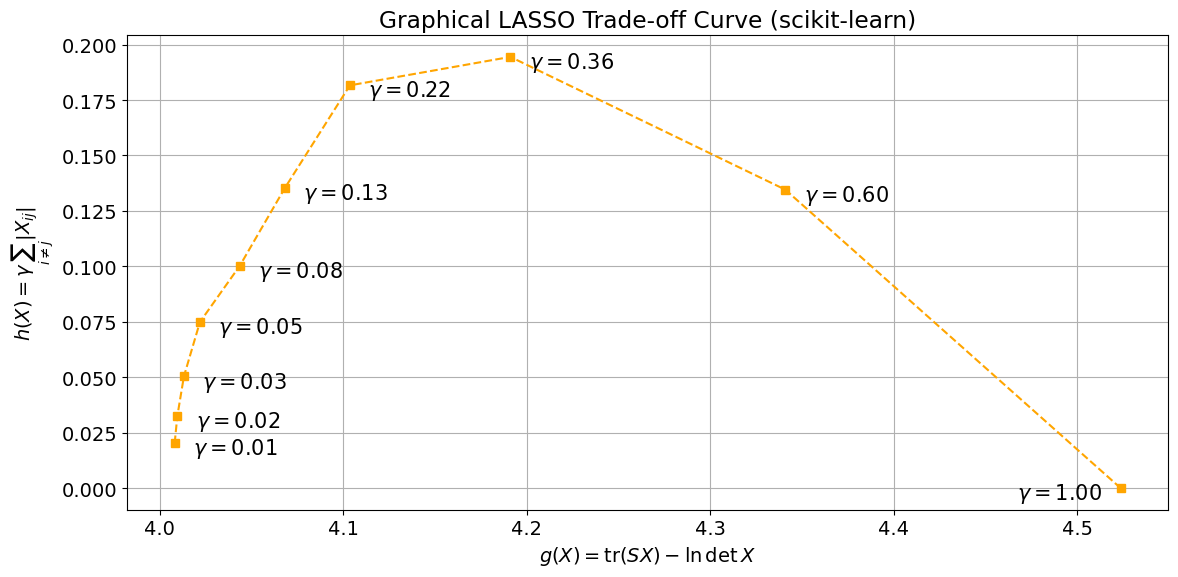

Is X_k positive definite? True


In [102]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import GraphicalLasso

# Helper functions
def compute_g(S, X):
    return np.trace(S @ X) - np.linalg.slogdet(X)[1]

def compute_h(X, gamma):
    return gamma * (np.sum(np.abs(X)) - np.sum(np.abs(np.diag(X))))


# Generate synthetic data with S as covariance
np.random.seed(42)
data = np.random.multivariate_normal(mean=np.zeros(4), cov=S, size=1000)

# Gamma values
gamma_vals = np.logspace(-2, 0, 10)
gs = []
hs = []

# Solve using sklearn
for gamma in gamma_vals:
    model = GraphicalLasso(alpha=gamma, max_iter=1000)
    model.fit(data)
    X_star = model.precision_
    g = compute_g(S, X_star)
    h = compute_h(X_star, gamma)
    gs.append(g)
    hs.append(h)
    print(f"Gamma: {gamma:.2f}, g(X): {g:.4f}, h(X): {h:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(gs, hs, marker='s', linestyle='--', color='orange', label='scikit-learn')
plt.xlabel(r'$g(X)=\operatorname{tr}(S X)-\ln \operatorname{det} X$')
plt.ylabel(r'$h(X)=\gamma \sum_{i \neq j}\left|X_{i j}\right|$')
plt.title('Graphical LASSO Trade-off Curve (scikit-learn)')
plt.grid(True)
plt.tight_layout()

# Annotate gamma values
for i, gamma in enumerate(gamma_vals[:-1]):
    plt.text(gs[i]+0.01, hs[i]-0.005, rf'$\gamma=${gamma:.2f}', fontsize=15, ha='left')
plt.text(gs[-1]-0.01, hs[-1]-0.005, rf'$\gamma=${gamma_vals[-1]:.2f}', fontsize=15, ha='right')

# Optional: save or just show
plt.savefig('graphical_lasso_tradeoff_sklearn.pdf', dpi=300)
plt.show()


print("Is X_k positive definite?", is_positive_definite(X_star))